In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import minmax_scale,StandardScaler

%matplotlib inline

In [2]:
def distplot_source_to_target(frame, source_col, target_col):
    def get_axes(axarr, unique_count, index):
        if int(np.ceil(uniq_count/5)) == 1:
            return axarr[index]
        else:
            return axarr[int(index/5)][int(index%5)]
                
    plt.figure(figsize=(7,5))
    left_tail = np.percentile(frame[target_col],5)
    right_tail = np.percentile(frame[target_col],95)
    temp = frame.loc[(frame[target_col]>left_tail)&(frame[target_col]<right_tail)]
    for f in sorted(frame[source_col].unique()):
        sns.distplot(temp.loc[temp[source_col]==f,target_col])
    plt.legend(sorted(frame[source_col].unique()))
    plt.show()
    
    uniq_count = frame[source_col].nunique()
    figure_row_count = int(np.ceil(uniq_count/5))
    fig, axarr = plt.subplots(figure_row_count, 5, figsize=(20, figure_row_count*4))
    for index, f in enumerate(sorted(train[source_col].unique())):
        axes = get_axes(axarr, uniq_count, index)
        temp = frame.loc[frame[source_col]==f,target_col]
        sns.distplot(temp,ax=axes)
        axes.set_title('{:.3f} {:.3f}'.format(temp.mean(),temp.std()))
    plt.tight_layout()
    plt.show()

In [3]:
def get_outlier_info(frame, col, q):
    percentile_val = np.percentile(frame[col],q)
    if q < 50:
        left_tail = frame.loc[frame[col]<=percentile_val].shape[0]
        print(percentile_val, left_tail, left_tail/frame.shape[0]*100)
    else:
        right_tail = frame.loc[frame[col]>=percentile_val].shape[0]
        print(percentile_val, right_tail, right_tail/frame.shape[0]*100)

In [4]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

merchants = pd.read_csv('input/merchants.csv')
historical_transactions = pd.read_csv('input/historical_transactions.csv')
new_merchant_transactions = pd.read_csv('input/new_merchant_transactions.csv')

### Train 데이터 분석

In [6]:
train.shape

(201917, 6)

In [7]:
train.columns

Index(['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3',
       'target'],
      dtype='object')

In [8]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [9]:
train.isnull().sum()

first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64

#### card_id
> * card_id는 이 문제의 key값, card_id당 고객 royalty 예측<br>
> * card_id는 valid함<br>
    - 혹시 몰라서 train, test 겹치는지, 뒤에 id로 split해서 겹치는지도 봤는데 겹치지 않음!<br>
> * 일단 card_id leak은 없어보임, 나중에 더 살펴봐야겠지만?
* card_id당 1명은 아닐수도?

In [10]:
train['card_id'].nunique() - train.shape[0]

0

In [11]:
train['card_id_split'] = train['card_id'].apply(lambda x: x.split('_')[-1])

In [12]:
set(test['card_id']).intersection(set(train['card_id']))

set()

In [13]:
test['card_id_split'] = test['card_id'].apply(lambda x: x.split('_')[-1])

In [14]:
train['card_id_split'].nunique() - train.shape[0]

0

In [15]:
test['card_id_split'].nunique() - test.shape[0]

0

In [16]:
set(test['card_id_split']).intersection(set(train['card_id_split']))

set()

#### target

아무래도 고객충성도가 -가 많은듯

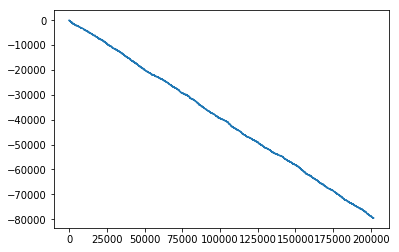

In [17]:
plt.plot(train['target'].cumsum())

skew가 - 값이고 첨도가 매우매우 큼

count    201917.000000
mean         -0.393636
std           3.850500
min         -33.219281
25%          -0.883110
50%          -0.023437
75%           0.765453
max          17.965068
Name: target, dtype: float64
-6.720159691530675
55.031783190452124


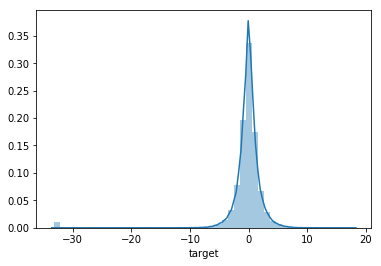

In [18]:
sns.distplot(train['target']);
print(train['target'].describe())
print(train['target'].skew())
print(train['target'].kurtosis())

1,5,95,99의 tail에 있는 항목들을 보니 조금 이상한데,<br>
1% 왼쪽은 -33인데 비해, 99%오른쪽은 4.8밖에 안됨. <br>
5와 95는 비슷

In [19]:
get_outlier_info(train,'target',1)
get_outlier_info(train,'target',5)
get_outlier_info(train,'target',95)
get_outlier_info(train,'target',99)

-33.21928095 2207 1.0930233709890698
-3.107835634 10096 5.0000742879499995
2.702680231999998 10096 5.0000742879499995
4.812662001999994 2020 1.000411059989996


좀 더 특이한 것은 -33.21928095란값이 2207개나 있다는 것<br>
이게 왜 이상하냐면, 충성도는 97%가 각기 다른 값을 가지고 있는데 특별하게 2000개 1%정도가 가장 안좋은 값을 가지고 있음<br>
이것은 메트릭이 rmse라 잘못 예측했을 경우 오차가 많이 발생할 수 있음, 이 항목은 따로 worst라는 feature를 추가하거나 따로 분석해 봐야함<br>
또한 0도 1630개나 있는데 따로 분석해봐야함!

In [20]:
train['target'].value_counts().head()

-33.219281    2207
 0.000000     1630
 1.000000      117
-1.000000       81
-0.584963       35
Name: target, dtype: int64

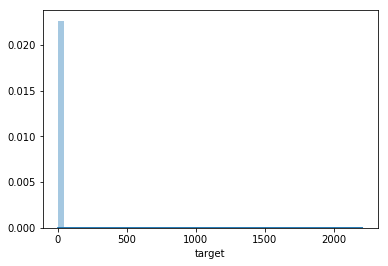

In [21]:
sns.distplot(train['target'].value_counts().reset_index()['target'])

In [22]:
np.sum(train['target'].value_counts()==1)/train['target'].shape[0]*100

97.42270338802578

target 값은 특이한 분포를 가지는데 -33.219281, 0.000000 값에 특히 약 1%씩 몰려있음

#### first_active_month
첫 구매한 월<br>
아마 마지막 1, 2월은 집계를 안한거겠지?

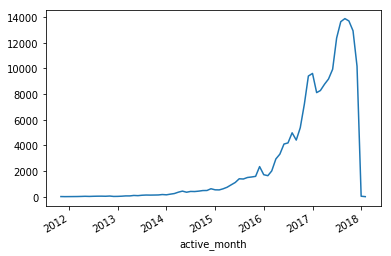

In [72]:
active_month = train['first_active_month'].value_counts().reset_index()
active_month.columns = ['active_month','count']
active_month = active_month.sort_values('active_month').reset_index(drop=True)
active_month.index = active_month.active_month
active_month['count'].plot()

In [24]:
train['first_active_month'] = pd.to_datetime(train['first_active_month'])

In [25]:
train['fromthefirstday'] = (datetime.now() - train['first_active_month']).dt.days

In [26]:
fromthefirstday_counts = train['fromthefirstday'].value_counts().reset_index()
fromthefirstday_counts.columns = ['fromthefirstday','count']

fromthefirstday_negative_ratio = (train.loc[train['target']<0].groupby(['fromthefirstday'])['target'].count()/train.groupby(['fromthefirstday'])['target'].count()).reset_index()
fromthefirstday_negative_ratio.columns = ['fromthefirstday','negative_ratio']

In [27]:
fromthefirstday = train.groupby(['fromthefirstday'])['target'].agg({'sum':'sum','mean':'mean'}).reset_index()
fromthefirstday = fromthefirstday.merge(fromthefirstday_counts,on='fromthefirstday',how='left')
fromthefirstday = fromthefirstday.merge(fromthefirstday_negative_ratio,on='fromthefirstday',how='left')
fromthefirstday.fillna(0,inplace=True)

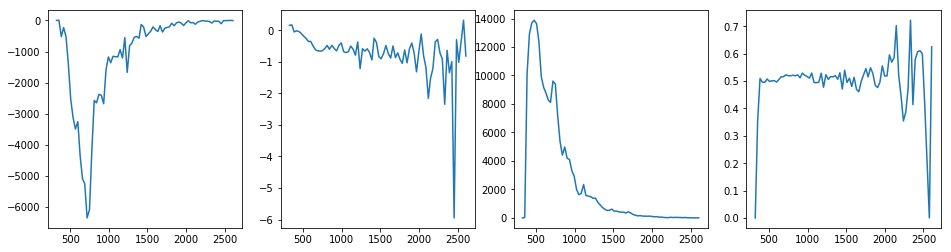

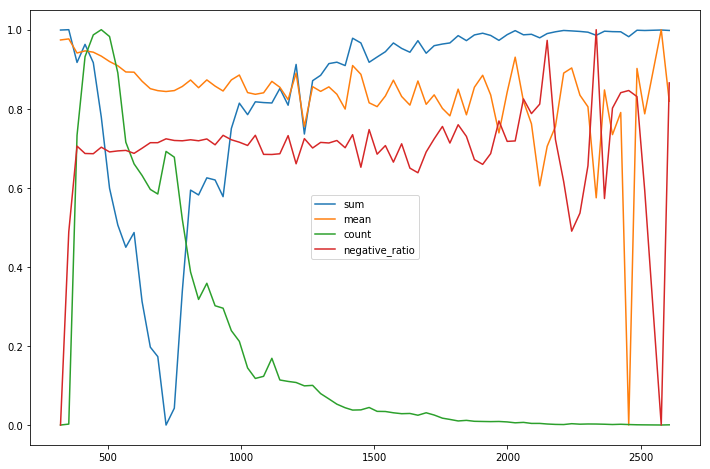

In [48]:
fig, axarr = plt.subplots(1,4,figsize=(16,4))
axarr[0].plot(fromthefirstday['fromthefirstday'],(fromthefirstday['sum']))
axarr[1].plot(fromthefirstday['fromthefirstday'],(fromthefirstday['mean']))
axarr[2].plot(fromthefirstday['fromthefirstday'],(fromthefirstday['count']))
axarr[3].plot(fromthefirstday['fromthefirstday'],(fromthefirstday['negative_ratio']))

plt.figure(figsize=(12,8))
plt.plot(fromthefirstday['fromthefirstday'],minmax_scale(fromthefirstday['sum']))
plt.plot(fromthefirstday['fromthefirstday'],minmax_scale(fromthefirstday['mean']))
plt.plot(fromthefirstday['fromthefirstday'],minmax_scale(fromthefirstday['count']))
plt.plot(fromthefirstday['fromthefirstday'],minmax_scale(fromthefirstday['negative_ratio']))
plt.legend(['sum','mean','count','negative_ratio']);

In [32]:
train['active_year'] = train['first_active_month'].dt.year

In [34]:
train['active_year'].value_counts()

2017    130519
2016     51277
2015     14142
2014      4523
2013      1129
2012       282
2018        35
2011        10
Name: active_year, dtype: int64

In [40]:
train.groupby(['active_year'])['target'].mean()

active_year
2011   -0.588494
2012   -1.243123
2013   -0.876205
2014   -0.768913
2015   -0.640495
2016   -0.573808
2017   -0.277227
2018    0.171504
Name: target, dtype: float64

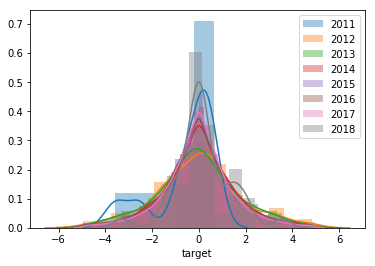

In [42]:
temp = train.loc[(train['target']<5)&(train['target']>-5)]
for y in sorted(temp['active_year'].unique()):
    sns.distplot(temp.loc[temp['active_year']==y,'target'])
plt.legend(sorted(temp['active_year'].unique()))

In [49]:
train['active_month'] = train['first_active_month'].dt.month

In [50]:
train['active_month'].value_counts()

12    22718
11    22403
10    21231
8     20552
9     20372
7     18490
6     15579
5     13953
4     12860
1     12050
3     11194
2     10515
Name: active_month, dtype: int64

이건 좀 이상하네? 보통 많으면 -가 되는데 반대인데?

active_month
1    -0.650622
2    -0.647671
3    -0.659870
4    -0.504383
5    -0.419818
6    -0.456248
7    -0.368388
8    -0.347458
9    -0.242229
10   -0.222813
11   -0.263514
12   -0.372914
Name: target, dtype: float64


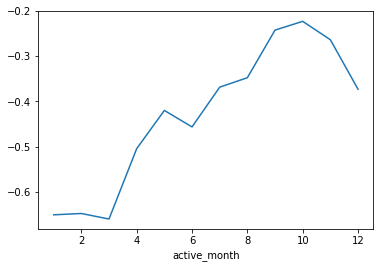

In [64]:
train.groupby(['active_month'])['target'].mean().plot()
print(train.groupby(['active_month'])['target'].mean())

In [73]:
train['active_day'] = train['first_active_month'].dt.day

In [74]:
train['active_day'].value_counts()

1    201917
Name: active_day, dtype: int64

#### feature_1, 2, 3 
>* category 변수이고 각각 5개, 3개, 2개 항목을 가지고 있음
>* 이상하리만큼 train, test의 분포가 같음
>* 각 category 항목마다 target값과의 분포가 거의 비슷함
>* 카드 종류 이런거겠네, 마침 Elo Site가보니까 개인용 카드 종류가 5개네? 너무갔나

In [17]:
train['feature_1'].nunique()

5

어찌 이리 train과 test가 똑같은 비율을 가지고 있을까.. 마치 일부러 이 비율을 같게 나눈것처럼

In [19]:
pd.concat([train['feature_1'].value_counts(), train['feature_1'].value_counts()/train.shape[0]*100],axis=1)

,feature_1,feature_1
3,73573,36.437249
2,55797,27.633632
5,40625,20.119653
4,19885,9.848106
1,12037,5.961360


In [20]:
pd.concat([test['feature_1'].value_counts(), test['feature_1'].value_counts()/test.shape[0]*100],axis=1)

,feature_1,feature_1
3,44719,36.173689
2,34115,27.595998
5,25051,20.264029
4,12332,9.975490
1,7406,5.990795


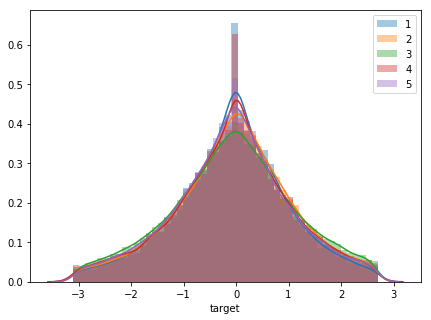

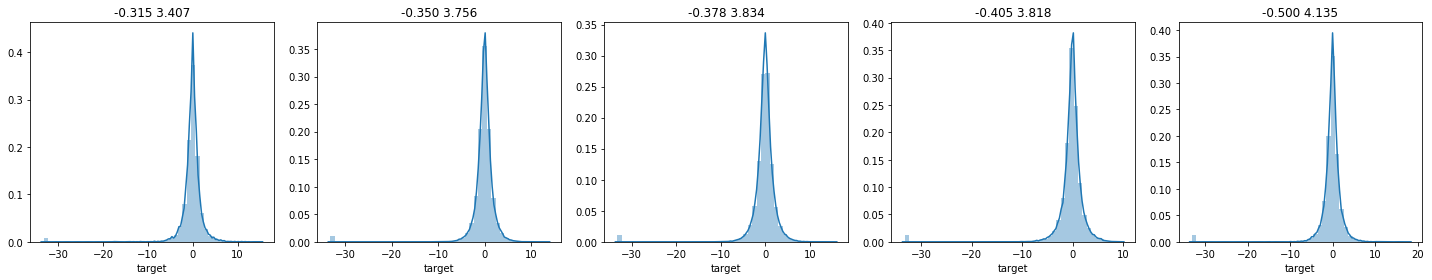

In [62]:
distplot_source_to_target(train,'feature_1','target')

In [123]:
train['feature_2'].nunique()

3

In [154]:
pd.concat([train['feature_2'].value_counts(), train['feature_2'].value_counts()/train.shape[0]*100],axis=1)

,feature_2,feature_2
1,89242,44.197368
2,74839,37.064239
3,37836,18.738393


In [155]:
pd.concat([test['feature_2'].value_counts(), test['feature_2'].value_counts()/test.shape[0]*100],axis=1)

,feature_2,feature_2
1,54775,44.308098
2,45993,37.204242
3,22855,18.487660


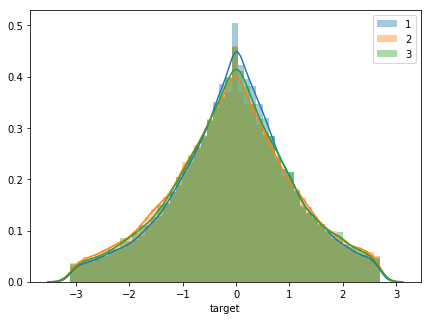

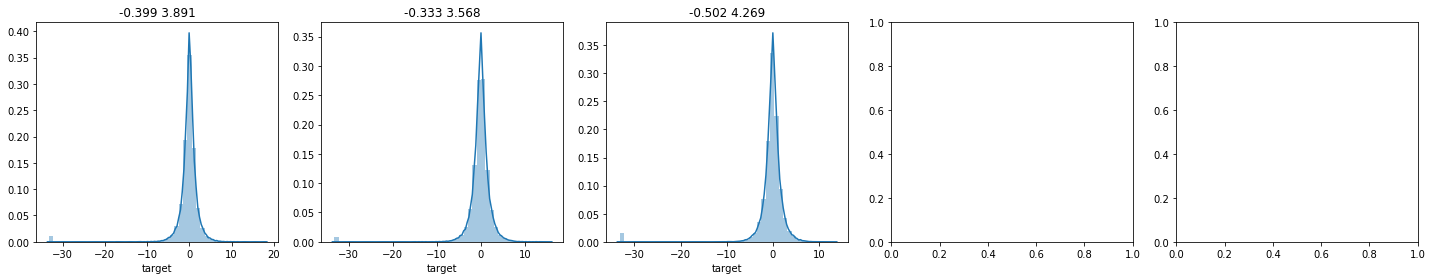

In [63]:
distplot_source_to_target(train,'feature_2','target')

In [126]:
train['feature_3'].nunique()

2

In [157]:
pd.concat([train['feature_3'].value_counts(), train['feature_3'].value_counts()/train.shape[0]*100],axis=1)

,feature_3,feature_3
1,114198,56.556902
0,87719,43.443098


In [156]:
pd.concat([test['feature_3'].value_counts(), test['feature_3'].value_counts()/test.shape[0]*100],axis=1)

,feature_3,feature_3
1,69770,56.437718
0,53853,43.562282


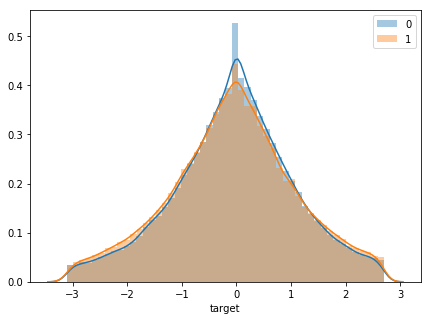

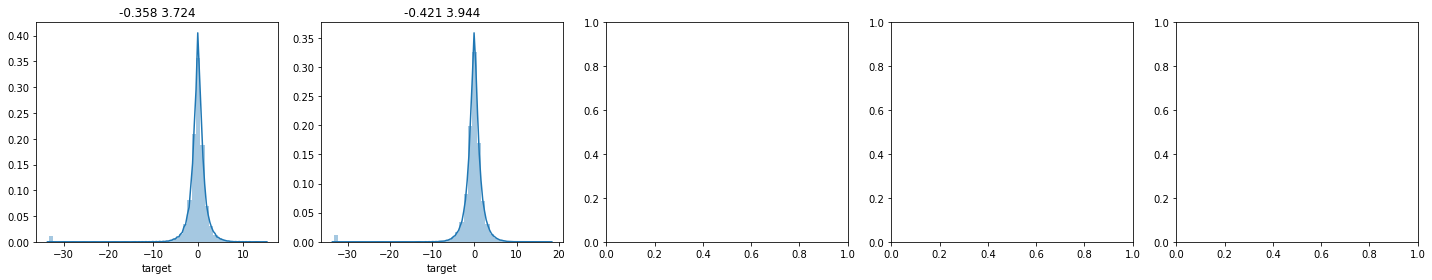

In [64]:
distplot_source_to_target(train, 'feature_3', 'target')

In [24]:
feature_list = ['feature_1','feature_2','feature_3']
for f in itertools.combinations(feature_list,2):
    train['{}_{}'.format(f[0], f[1])] = train[f[0]].astype(str) + '_' + train[f[1]].astype(str)
    test['{}_{}'.format(f[0], f[1])] = test[f[0]].astype(str) + '_' + test[f[1]].astype(str)

In [26]:
pd.concat([train['feature_1_feature_2'].value_counts(), train['feature_1_feature_2'].value_counts()/train.shape[0]*100],axis=1)

,feature_1_feature_2,feature_1_feature_2
3_1,24610,12.188176
3_3,24546,12.156480
2_1,24502,12.134689
2_2,24469,12.118346
5_1,24428,12.098040
3_2,24417,12.092593
5_2,16197,8.021613
4_1,9194,4.553356
4_2,6923,3.428637
2_3,6826,3.380597


In [27]:
pd.concat([test['feature_1_feature_2'].value_counts(), test['feature_1_feature_2'].value_counts()/train.shape[0]*100],axis=1)

,feature_1_feature_2,feature_1_feature_2
5_1,15101,7.478816
2_2,15066,7.461482
3_2,14996,7.426814
2_1,14933,7.395613
3_3,14905,7.381746
3_1,14818,7.338659
5_2,9950,4.927767
4_1,5846,2.895249
4_2,4248,2.103835
2_3,4116,2.038461


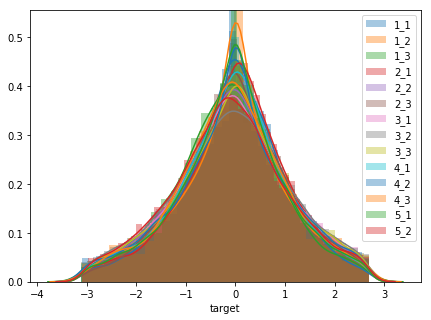

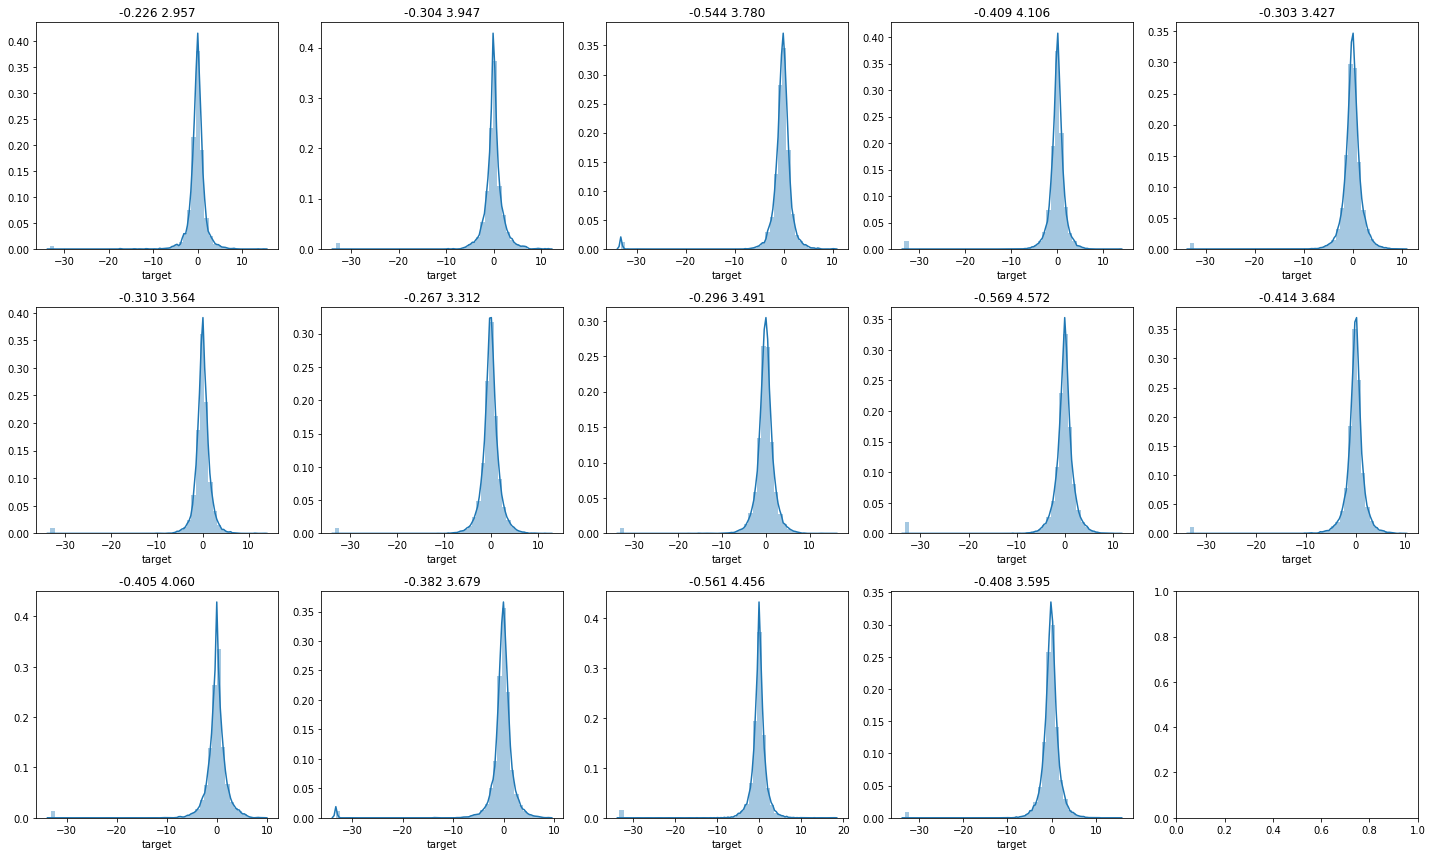

In [65]:
distplot_source_to_target(train, 'feature_1_feature_2', 'target')

In [28]:
pd.concat([train['feature_2_feature_3'].value_counts(), train['feature_2_feature_3'].value_counts()/train.shape[0]*100],axis=1)

,feature_2_feature_3,feature_2_feature_3
1_1,49038,24.286217
2_1,40614,20.114205
1_0,40204,19.911152
2_0,34225,16.950034
3_1,24546,12.156480
3_0,13290,6.581912


In [29]:
pd.concat([test['feature_2_feature_3'].value_counts(), test['feature_2_feature_3'].value_counts()/train.shape[0]*100],axis=1)

,feature_2_feature_3,feature_2_feature_3
1_1,29919,14.817475
2_1,24946,12.354581
1_0,24856,12.310009
2_0,21047,10.423590
3_1,14905,7.381746
3_0,7950,3.937261


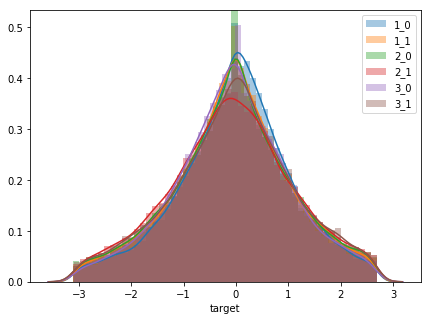

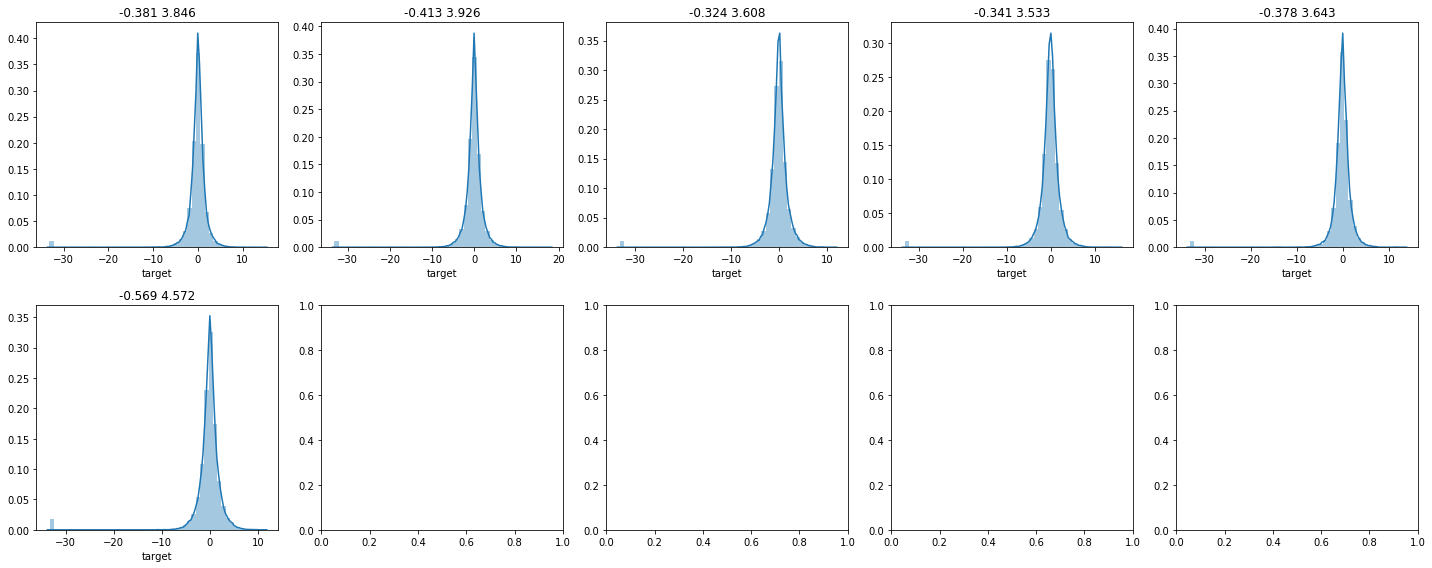

In [66]:
distplot_source_to_target(train, 'feature_2_feature_3', 'target')

In [30]:
pd.concat([train['feature_1_feature_3'].value_counts(), train['feature_1_feature_3'].value_counts()/train.shape[0]*100],axis=1)

,feature_1_feature_3,feature_1_feature_3
3_1,73573,36.437249
2_0,55797,27.633632
5_1,40625,20.119653
4_0,19885,9.848106
1_0,12037,5.961360


In [31]:
pd.concat([test['feature_1_feature_3'].value_counts(), test['feature_1_feature_3'].value_counts()/train.shape[0]*100],axis=1)

,feature_1_feature_3,feature_1_feature_3
3_1,44719,22.147219
2_0,34115,16.895556
5_1,25051,12.406583
4_0,12332,6.107460
1_0,7406,3.667844


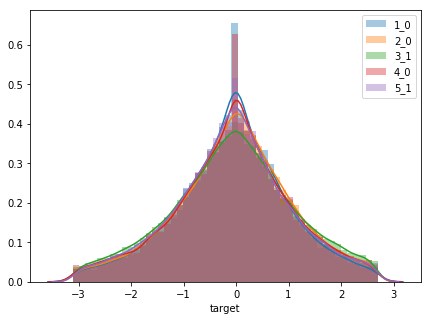

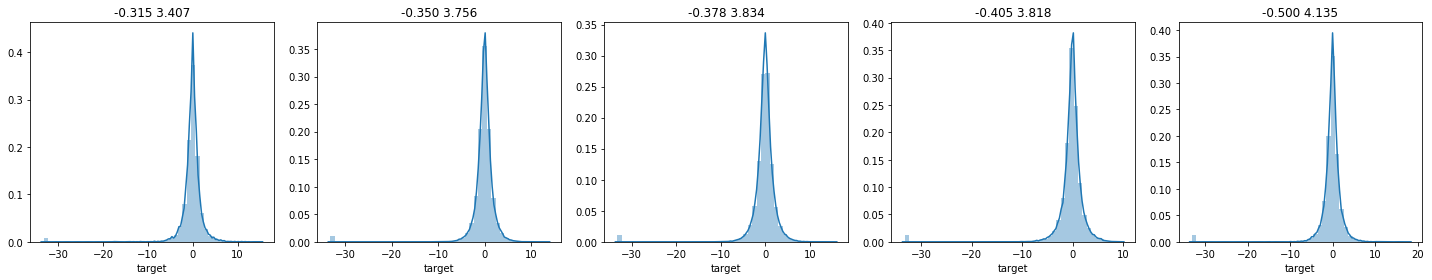

In [67]:
distplot_source_to_target(train, 'feature_1_feature_3', 'target')

In [32]:
train['feature_123'] = train['feature_1'].astype(str) + '_' + train['feature_2'].astype(str) + '_' + train['feature_3'].astype(str)
test['feature_123'] = test['feature_1'].astype(str) + '_' + test['feature_2'].astype(str) + '_' + test['feature_3'].astype(str)

feature1_2의 combination과 123의 combination의 비율이 완전 같음<br>
즉 feature1,2가 결정되면 3은 같은 항목에 하나밖에 없음<br>
5_1일 경우에는 무조건 1, 2_2면 0 이런식<br>
이게 도움을 줄까? category combination시 123은 할 필요가 없음<br>

In [33]:
pd.concat([train['feature_123'].value_counts(), train['feature_123'].value_counts()/train.shape[0]*100],axis=1)

,feature_123,feature_123
3_1_1,24610,12.188176
3_3_1,24546,12.156480
2_1_0,24502,12.134689
2_2_0,24469,12.118346
5_1_1,24428,12.098040
3_2_1,24417,12.092593
5_2_1,16197,8.021613
4_1_0,9194,4.553356
4_2_0,6923,3.428637
2_3_0,6826,3.380597


In [34]:
pd.concat([test['feature_123'].value_counts(), test['feature_123'].value_counts()/train.shape[0]*100],axis=1)

,feature_123,feature_123
5_1_1,15101,7.478816
2_2_0,15066,7.461482
3_2_1,14996,7.426814
2_1_0,14933,7.395613
3_3_1,14905,7.381746
3_1_1,14818,7.338659
5_2_1,9950,4.927767
4_1_0,5846,2.895249
4_2_0,4248,2.103835
2_3_0,4116,2.038461


feature간 충성도 분포 차이가 거의 없네

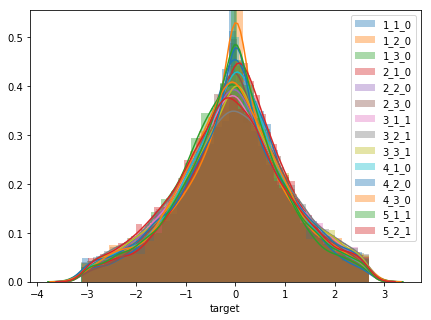

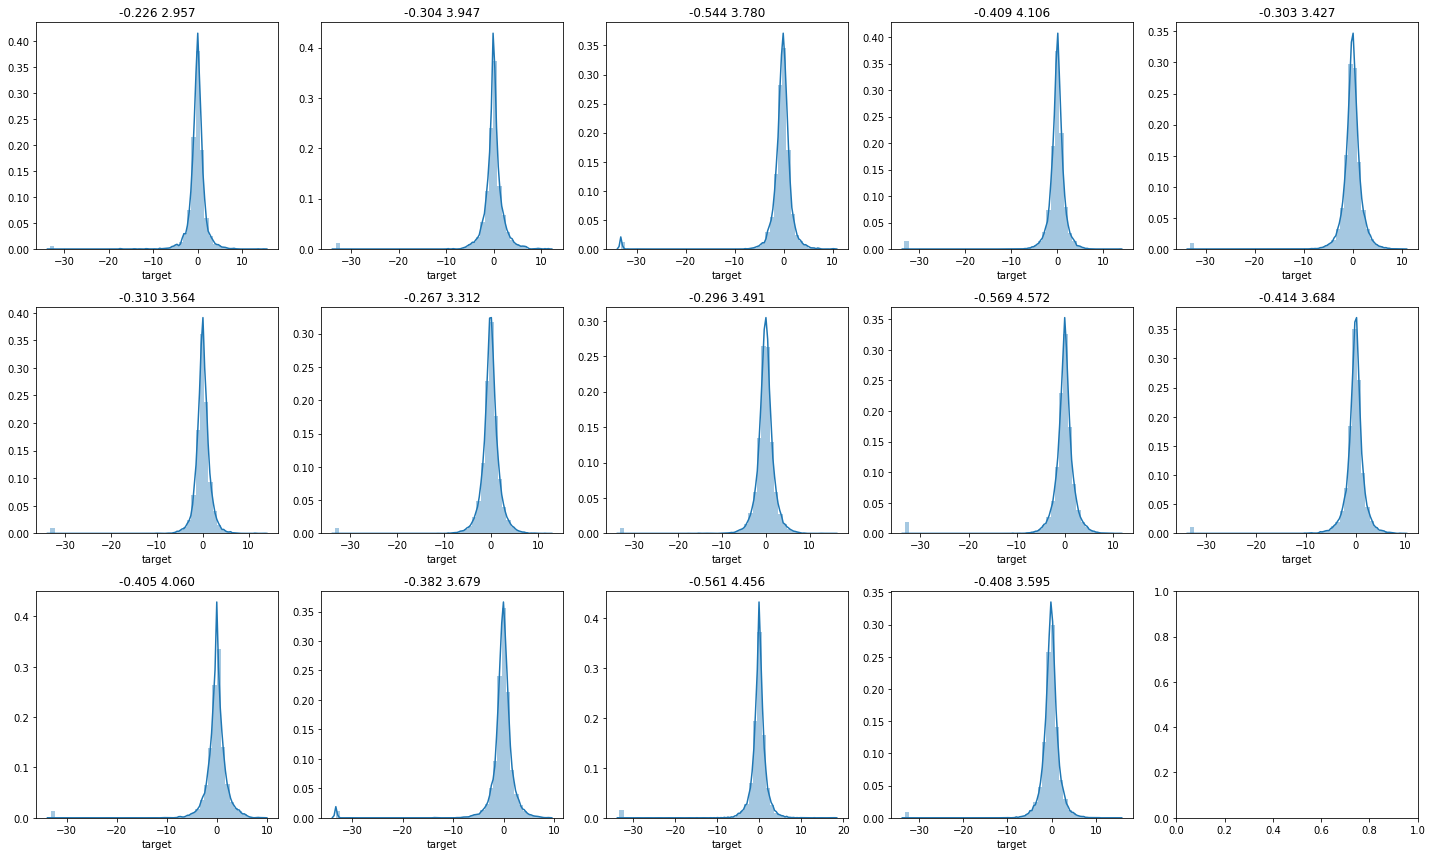

In [68]:
distplot_source_to_target(train, 'feature_123', 'target')

# Historical Transaction

In [5]:
all_data = pd.concat([train,test])

In [6]:
historical_transactions = historical_transactions.merge(all_data,on='card_id',how='left')

In [7]:
historical_transactions.shape

(29112361, 19)

In [8]:
historical_transactions.columns

Index(['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'purchase_date', 'category_2', 'state_id',
       'subsector_id', 'feature_1', 'feature_2', 'feature_3',
       'first_active_month', 'target'],
      dtype='object')

In [9]:
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,feature_1,feature_2,feature_3,first_active_month,target
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,3,3,1,2016-06,NaN
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,3,3,1,2016-06,NaN
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,3,3,1,2016-06,NaN
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34,3,3,1,2016-06,NaN
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37,3,3,1,2016-06,NaN


historical_transaction에 11082352 은 test에 관련된 내용 약 38% 


In [10]:
11082352/historical_transactions.shape[0] * 100

38.06751365854525

In [11]:
historical_transactions.isnull().sum()

authorized_flag                0
card_id                        0
city_id                        0
category_1                     0
installments                   0
category_3                178159
merchant_category_id           0
merchant_id               138481
month_lag                      0
purchase_amount                0
purchase_date                  0
category_2               2652864
state_id                       0
subsector_id                   0
feature_1                      0
feature_2                      0
feature_3                      0
first_active_month            55
target                  11082352
dtype: int64

first_active_month

####  authorized_flag
category feature<br>
'Y' if approved, 'N' if denied

In [46]:
historical_transactions['authorized_flag'].unique()

array(['Y', 'N'], dtype=object)

오 거절이 꽤 있네? 한도초과 이런건가?

In [47]:
historical_transactions['authorized_flag'].value_counts()

Y    26595452
N     2516909
Name: authorized_flag, dtype: int64

In [76]:
historical_transactions.loc[historical_transactions['target'].notnull(),'authorized_flag'].value_counts()/historical_transactions.loc[historical_transactions['target'].notnull()].shape[0]*100

Y    91.33742
N     8.66258
Name: authorized_flag, dtype: float64

In [75]:
historical_transactions.loc[historical_transactions['target'].isnull(),'authorized_flag'].value_counts()/historical_transactions.loc[historical_transactions['target'].isnull()].shape[0]*100

Y    91.38229
N     8.61771
Name: authorized_flag, dtype: float64

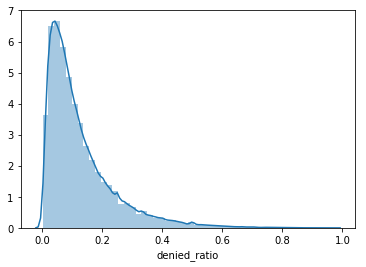

In [40]:
sns.distplot(card_authorized_denied['denied_ratio'].dropna())

In [23]:
historical_transactions.loc[historical_transactions['authorized_flag']=='N','card_id'].value_counts().head()

C_ID_5ea401d358    1510
C_ID_3d3dfdc692    1460
C_ID_5e10990e53     516
C_ID_e75e342f15     515
C_ID_266c2f1192     470
Name: card_id, dtype: int64

In [78]:
card_authorized_denied = historical_transactions.loc[historical_transactions['authorized_flag']=='N','card_id'].value_counts()/historical_transactions['card_id'].value_counts()
card_authorized_denied = card_authorized_denied.reset_index()
card_authorized_denied.columns = ['card_id','denied_ratio']
card_authorized_denied = card_authorized_denied.sort_values('denied_ratio',ascending=False)
card_authorized_denied.reset_index(drop=True,inplace=True)
card_authorized_denied = card_authorized_denied.merge(train[['card_id','first_active_month','target']],on='card_id',how='left')

In [36]:
card_authorized_denied.loc[card_authorized_denied['denied_ratio'].isnull()].shape[0]/card_authorized_denied.shape[0]*100

15.309639368433986

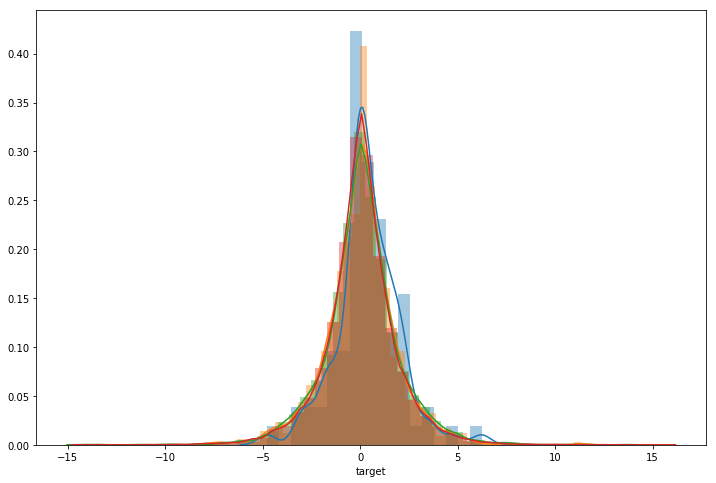

In [70]:
plt.figure(figsize=(12,8))
sns.distplot(card_authorized_denied.loc[(card_authorized_denied['target']>-15)&(card_authorized_denied['denied_ratio']>0.8),'target'].dropna())
sns.distplot(card_authorized_denied.loc[(card_authorized_denied['target']>-15)&(0.6<card_authorized_denied['denied_ratio'])&(card_authorized_denied['denied_ratio']<=0.8),'target'].dropna())
sns.distplot(card_authorized_denied.loc[(card_authorized_denied['target']>-15)&(0.4<card_authorized_denied['denied_ratio'])&(card_authorized_denied['denied_ratio']<=0.6),'target'].dropna())
sns.distplot(card_authorized_denied.loc[(card_authorized_denied['target']>-15)&(0.2<card_authorized_denied['denied_ratio'])&(card_authorized_denied['denied_ratio']<=0.4),'target'].dropna())

In [71]:
card_authorized_denied['target']

0          2.216685
1         -1.695134
2         -0.221074
3               NaN
4               NaN
5               NaN
6        -33.219281
7          1.281568
8               NaN
9         -0.118473
10              NaN
11         1.083606
12         0.000000
13         1.194803
14        -1.828574
15              NaN
16              NaN
17              NaN
18         0.401495
19        -1.044135
20              NaN
21         0.474653
22        -2.986294
23         1.686489
24         1.771834
25              NaN
26        -0.123215
27         1.190639
28        -0.030815
29         1.000000
            ...    
325510    -3.243989
325511     2.530419
325512     1.158880
325513    -1.686818
325514    -0.809903
325515    -1.902830
325516     4.126856
325517          NaN
325518     4.405158
325519     0.819476
325520    -0.545937
325521    -0.300085
325522          NaN
325523     2.212517
325524    -0.598374
325525     0.518986
325526     0.633487
325527    -0.524350
325528          NaN


####  month_lag
category feature<br>
'Y' if approved, 'N' if denied

In [83]:
historical_transactions['month_lag'].min(),historical_transactions['month_lag'].max()

(-13, 0)

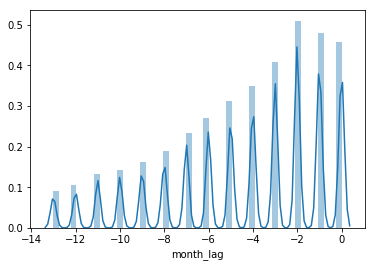

In [81]:
sns.distplot(historical_transactions['month_lag'])

# Merchants

In [37]:
merchants.shape

(334696, 22)

In [38]:
merchants.columns

Index(['merchant_id', 'merchant_group_id', 'merchant_category_id',
       'subsector_id', 'numerical_1', 'numerical_2', 'category_1',
       'most_recent_sales_range', 'most_recent_purchases_range',
       'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3',
       'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6',
       'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12',
       'category_4', 'city_id', 'state_id', 'category_2'],
      dtype='object')

In [39]:
merchants.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,...,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [40]:
merchants.describe()

,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,city_id,state_id,category_2
count,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334683.000000,3.346960e+05,334696.000000,3.346830e+05,3.346960e+05,334696.000000,3.346830e+05,3.346960e+05,334696.000000,334696.000000,334696.000000,322809.000000
mean,31028.736143,423.131663,25.116404,0.011476,0.008103,13.832993,inf,2.994108,2.165079e+01,inf,5.947397,2.522771e+01,inf,11.599335,102.917926,11.860942,2.380002
std,31623.043426,252.898046,9.807371,1.098154,1.070497,2395.489999,NaN,0.095247,3.947108e+03,NaN,0.394936,5.251842e+03,NaN,1.520138,107.090673,6.176889,1.562661
min,1.000000,-1.000000,-1.000000,-0.057471,-0.057471,-82.130000,3.334953e-01,1.000000,-8.213000e+01,1.670447e-01,1.000000,-8.213000e+01,9.832954e-02,1.000000,-1.000000,-1.000000,1.000000
25%,3612.000000,222.000000,19.000000,-0.057471,-0.057471,0.880000,9.236499e-01,3.000000,8.500000e-01,9.022475e-01,6.000000,8.500000e-01,8.983333e-01,12.000000,-1.000000,9.000000,1.000000
50%,19900.000000,373.000000,27.000000,-0.057471,-0.057471,1.000000,1.016667e+00,3.000000,1.010000e+00,1.026961e+00,6.000000,1.020000e+00,1.043361e+00,12.000000,69.000000,9.000000,2.000000
75%,51707.250000,683.000000,33.000000,-0.047556,-0.047556,1.160000,1.146522e+00,3.000000,1.230000e+00,1.215575e+00,6.000000,1.290000e+00,1.266480e+00,12.000000,182.000000,16.000000,4.000000
max,112586.000000,891.000000,41.000000,183.735111,182.079322,851844.640000,inf,3.000000,1.513959e+06,inf,6.000000,2.567408e+06,inf,12.000000,347.000000,24.000000,5.000000


In [41]:
merchants.merchant_group_id.nunique()

109391